In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import json
import numpy as np
import tensorflow as tf
import math

2024-08-22 11:35:23.301142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/macfarqu/Desktop/My_Projects/PCGML/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def display_level_image(tile_dim, level, tile_name_to_image):
    level_image = Image.new("RGB", (tile_dim[1] * len(level[0]), tile_dim[1] * len(level) ))
    for row in range(len(level)):
        for col in range(len(level[0])):
            level_image.paste(tile_name_to_image[level[row][col]],(col * tile_dim[0], row * tile_dim[1], (col+1) * tile_dim[0], (row +1) *tile_dim[1]))
    
    plt.figure()
    plt.imshow(level_image)
    plt.show()
    

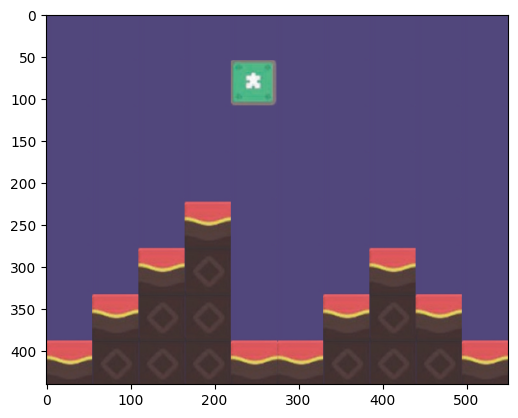

In [3]:
tile_name_to_image = {}
tiles = ["A", "B", "C", "G", "K"]
for tile in tiles:
    tile_name_to_image[tile] = Image.open(f'tiles/{tile}.png')
    
tile_dim = tile_name_to_image["A"].size
with open("levels.json", 'r') as file:
    levels = json.load(file)

# pick any of the 4 levels to view
display_level_image(tile_dim, levels[3], tile_name_to_image)

# Create Height Neural Network

In [4]:
embedding_map = {
    "A": 0,
    "B": 1,
    "C": 2,
    "G": 3,
    "K": 4
}

X = []
Y = []
column_context = 2

for level in levels:
    columns = []
    for col in range(len(level[0])):
        columns.append([embedding_map[level[i][col]] for i in range(len(level))])

    for col in range(len(columns) - column_context):
        x_entry = [columns[col + i] for i in range(column_context)]
        X.append(x_entry)
        first_non_empty = next((i for i, value in enumerate(columns[col + column_context]) if value != 0), len(columns[col + column_context]))
        height = len(columns[col + column_context]) - first_non_empty
        Y.append(height)
        
X = np.array(X)
X = X.reshape(-1, X.shape[1] * X.shape[2])

Y = np.array(Y)
Y = Y.reshape(-1,1)

print(X)
print(Y)


[[0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 2]
 [0 0 0 1 0 0 0 2 0 0 0 0 0 0 2 4]
 [0 0 0 0 0 0 2 4 0 0 0 0 3 2 4 4]
 [0 0 0 0 3 2 4 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 4 4]
 [0 0 0 0 0 2 4 4 0 0 0 0 0 2 4 4]
 [0 0 0 0 0 2 4 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 4 4]
 [0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 2]
 [0 0 0 1 0 0 0 2 0 0 0 0 0 0 2 4]
 [0 0 0 0 0 0 2 4 0 0 0 0 0 2 4 4]
 [0 0 0 0 0 2 4 4 0 0 0 0 0 2 4 4]
 [0 0 0 0 0 2 4 4 0 0 1 0 0 2 4 4]
 [0 0 1 0 0 2 4 4 0 0 1 0 0 2 4 4]
 [0 0 1 0 0 2 4 4 0 0 0 0 0 0 2 4]
 [0 0 0 0 0 0 2 4 0 0 0 0 0 2 4 4]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 4]
 [0 0 0 0 0 0 2 4 0 0 0 0 0 2 4 4]
 [0 0 0 0 0 2 4 4 0 0 0 0 2 4 4 4]
 [0 0 0 0 2 4 4 4 0 1 0 0 0 0 0 2]
 [0 1 0 0 0 0 0 2 0 

In [5]:
hidden_layer_nodes = 8
rows = len(levels[0])
height_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(hidden_layer_nodes, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(hidden_layer_nodes, activation='relu'),
    tf.keras.layers.Dense(1)
])

height_model.compile(optimizer='adam',
              loss='mean_squared_error')

height_model.fit(X, Y, epochs=500)

Epoch 1/500


/Users/macfarqu/Desktop/My_Projects/PCGML/venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step - loss: 11.6058
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 11.4709
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 11.3387
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 11.2174
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 11.0979
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.9797
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 10.8629
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 10.7475
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 10.6362
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 10.5335
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 10.4327
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.3336
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 10.2353
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 10.1397
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 10.0465
Epoch 16/500
1

# Create Content Neural Network


In [6]:
X = []
Y = []

for level in levels:
    for row in range(len(level)):
        for col in range(len(level[0])):
            if row == len(level) - 1:
                below = -1
            else:
                below = embedding_map[level[row+1][col]]
            if col == 0:
                left = -1
            else:
                left = embedding_map[level[row][col-1]]
                
            x_left = [1 if i == left else 0 for i in range(-1, 5)]
            x_below = [1 if i == below else 0 for i in range(-1, 5)]
            x = x_left + x_below
            X.append(x)
            
            y = level[row][col]
            Y.append([1 if i == embedding_map[y] else 0 for i in range(5)])
        
X = np.array(X)

Y = np.array(Y)
Y = Y.reshape(-1,5)

print(X)
print(Y)

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 0]]


In [7]:
hidden_layer_nodes = 8
num_categories = 5
content_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(hidden_layer_nodes, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(hidden_layer_nodes, activation='relu'),
    tf.keras.layers.Dense(num_categories, activation='softmax')
])

content_model.compile(optimizer='adam',
              loss='categorical_crossentropy')

content_model.fit(X, Y, epochs=250)

Epoch 1/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7025
Epoch 2/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6427 
Epoch 3/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5788 
Epoch 4/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5260
Epoch 5/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4827 
Epoch 6/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4475 
Epoch 7/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3981 
Epoch 8/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3648 
Epoch 9/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3125 
Epoch 10/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2745 
Epoch 11/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2119 
Epoch 12/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1731 
Epoch 13/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1385 
Epoch 14/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0746 
Epoch 15/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss:

# Generating Levels

In [8]:
def generate_level(context_cols, num_cols_to_generate, column_height, height_model, content_model):
    level = context_cols

    for i in range(num_cols_to_generate):
        next_height = 8 #round(height_model.predict(np.array(context_cols).reshape(1,16))[0][0])
        next_col = [0] * column_height
        for i in range(next_height):
            if i == 0:
                below = -1
            else:
                below = next_col[column_height - i]
            left = context_cols[1][column_height - 1 - i]
            x_left = [1 if i == left else 0 for i in range(-1, 5)]
            x_below = [1 if i == below else 0 for i in range(-1, 5)]
            x = x_left + x_below

            logits = content_model.predict(np.array(x).reshape(1,12))
            content_pred = np.random.choice(np.array(range(5)), p=logits[0])
            next_col[column_height - 1 - i] = content_pred
        context_cols = [context_cols[1], next_col]
        level.append(next_col)
    return level

def translate_level(level):
    reverse_embedding_map = ["A","B","C","G","K"]
    transposed_level = [list(row) for row in zip(*level)]

    for row in range(len(transposed_level)):
        for col in range(len(transposed_level[0])):
            transposed_level[row][col] = reverse_embedding_map[transposed_level[row][col]]

    return transposed_level


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

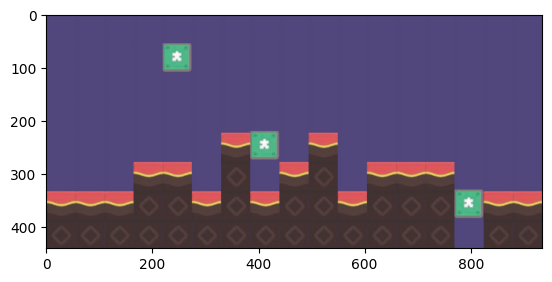

In [10]:
context_cols = [[0, 0, 0, 0, 0, 0, 2, 4],
                    [0, 0, 0, 0, 0, 0, 2, 4]]
level = translate_level(generate_level(context_cols, 15, 8, height_model, content_model))
display_level_image(tile_dim, level, tile_name_to_image)